## Accessing TerraClimate data on Azure

[TerraClimate](http://www.climatologylab.org/terraclimate.html) is a dataset of monthly climate and climatic water balance for global terrestrial surfaces from 1958-2019. These data provide important inputs for ecological and hydrological studies at global scales that require high spatial resolution and time-varying data. All data have monthly temporal resolution and a ~4-km (1/24th degree) spatial resolution. The data cover the period from 1958-2019.

This example will show you how temperature has increased over the past 60 years across the globe.

This dataset is stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in the same region.  If you are using this data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

This dataset is documented in the [Planetary Computer data catalog](https://planetarycomputer-staging.microsoft.com/dataset/terraclimate).

In [1]:
import warnings

warnings.filterwarnings("ignore", "invalid value", RuntimeWarning)

### Data Access

https://planetarycomputer-staging.microsoft.com/api/stac/v1/collections/terraclimate is a STAC Collection with links to all the metadata about this dataset. We'll load it with [PySTAC](https://pystac.readthedocs.io/en/latest/).

In [2]:
import pystac

url = "https://planetarycomputer-staging.microsoft.com/api/stac/v1/collections/terraclimate"
collection = pystac.read_file(url)
collection

<Collection id=terraclimate>

The collection contains assets, which are links to the root of a Zarr store, which can be opened with xarray.

In [3]:
asset = collection.assets["zarr-https"]
asset

<Asset href=https://cpdataeuwest.blob.core.windows.net/cpdata/raw/terraclimate/4000m/raster.zarr>

In [4]:
import fsspec
import xarray as xr

store = fsspec.get_mapper(asset.href)
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
ds

,Array,Chunk
Bytes,103.45 GiB,94.92 MiB
Shape,"(744, 4320, 8640)","(12, 1440, 1440)"
Count,1117 Tasks,1116 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,103.45 GiB,94.92 MiB
Shape,"(744, 4320, 8640)","(12, 1440, 1440)"
Count,1117 Tasks,1116 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


We'll process the data in parallel using [Dask](https://dask.org).

In [5]:
import dask
from dask.distributed import Client

client = Client(processes=False)
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


The link printed out above is a can be opened in the [Dask labextension](https://github.com/dask/dask-labextension). See [Scale with Dask](https://planetarycomputer.microsoft.com/docs/quickstarts/scale-with-dask/) for more on using Dask, and how to access the Dashboard.

### Analyze and plot global temperature

We can quickly plot a map of one of the variables. In this case, we are downsampling (coarsening) the dataset for easier plotting.

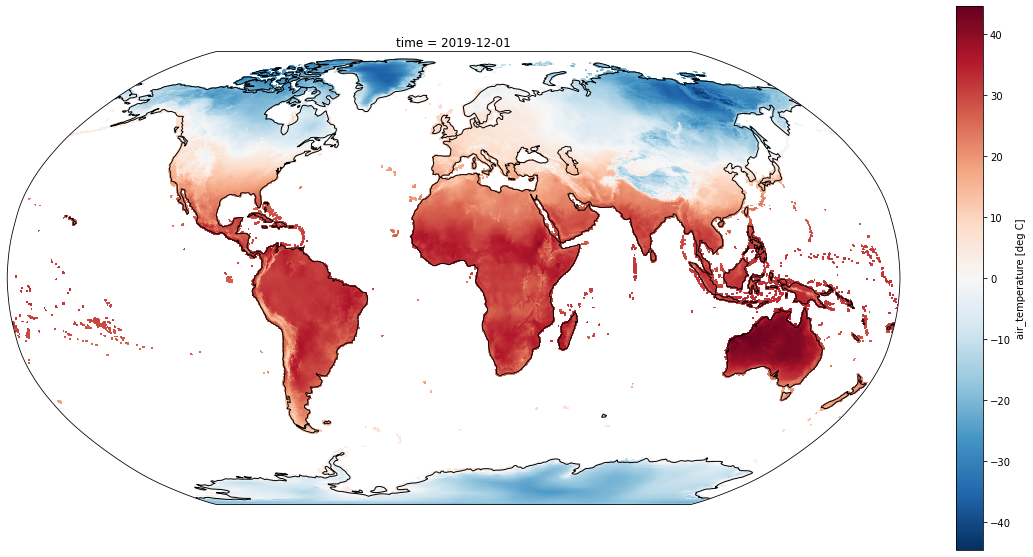

In [6]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


average_max_temp = ds.isel(time=-1)["tmax"].coarsen(lat=8, lon=8).mean().load()

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(projection=ccrs.Robinson()))

average_max_temp.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines();

Let's see how temperature has changed over the observational record, when averaged across the entire domain. Since we'll do some other calculations below we'll also add `.load()` to execute the command instead of specifying it lazily.  Note that there are some data quality issues before 1965 so we'll start our analysis there.

In [7]:
%%time
temperature = ds["tmax"].sel(time=slice("1965", None)).mean(dim=["lat", "lon"]).load()

CPU times: user 3min 56s, sys: 1min 22s, total: 5min 18s
Wall time: 2min 9s


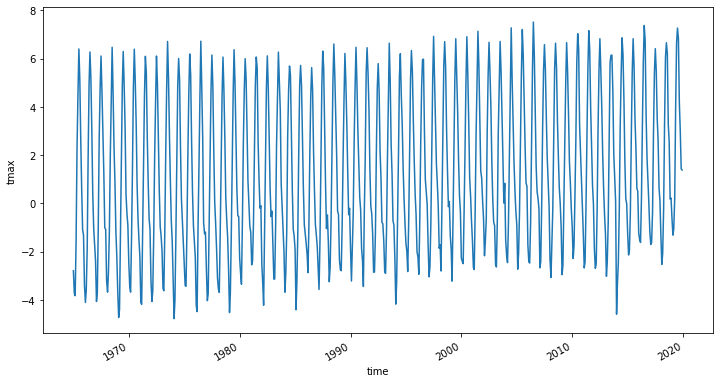

In [8]:
temperature.plot(figsize=(12, 6));

With all the seasonal fluctuations (from summer and winter) though, it can be hard to see any obvious trends. So let's try grouping by year and plotting that timeseries.

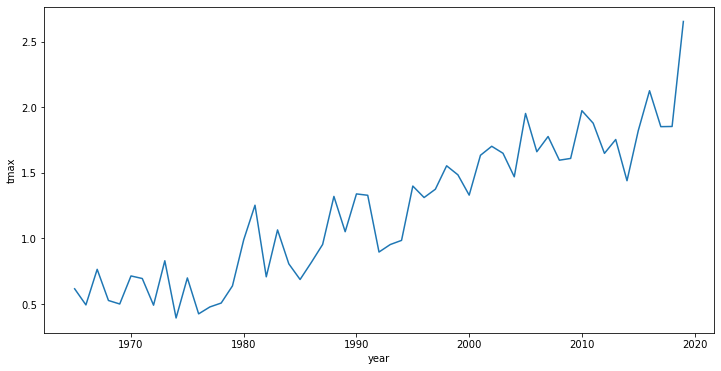

In [9]:
temperature.groupby("time.year").mean().plot(figsize=(12, 6));

Now the increase in temperature is obvious, even when averaged across the entire domain.

Now, let's see how those changes are different in different parts of the world. And let's focus just on summer months in the northern hemisphere, when it's hottest. Let's take a climatological slice at the beginning of the period and the same at the end of the period, calculate the difference, and map it to see how different parts of the world have changed differently.

First we'll just grab the summer months.

In [10]:
%%time
summer_months = [6, 7, 8]
summer = ds.tmax.where(ds.time.dt.month.isin(summer_months), drop=True)

early_period = slice("1958-01-01", "1988-12-31")
late_period = slice("1988-01-01", "2018-12-31")

early, late = dask.compute(
    summer.sel(time=early_period).mean(dim="time"),
    summer.sel(time=late_period).mean(dim="time"),
)
increase = (late - early).coarsen(lat=8, lon=8).mean()

CPU times: user 3min 24s, sys: 1min 4s, total: 4min 28s
Wall time: 2min


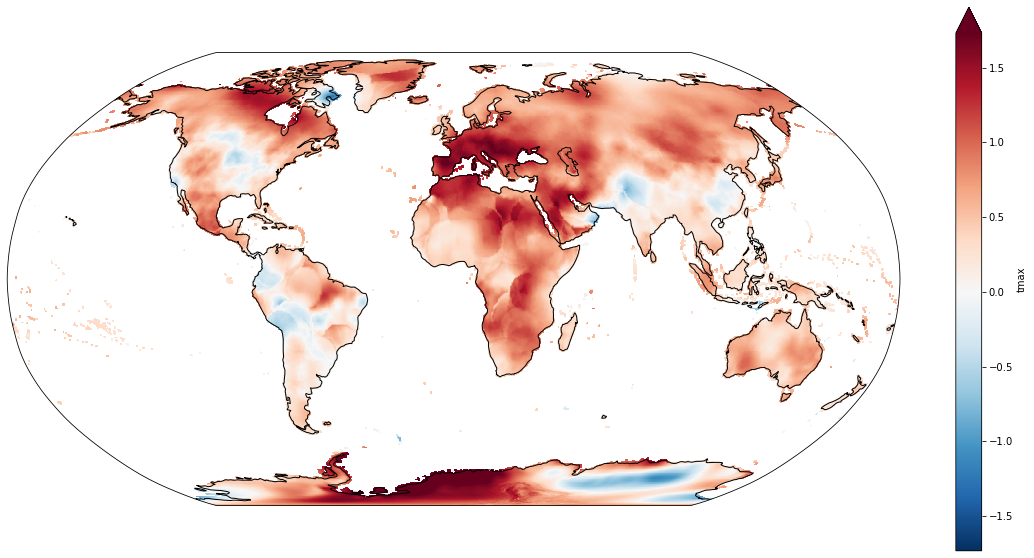

In [11]:
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(projection=ccrs.Robinson()))

increase.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True)
ax.coastlines();

This shows us that changes in summer temperature haven't been felt equally around the globe.  Note the enhanced warming in the polar regions, a phenomenon known as "Arctic amplification".